In [2]:
import os 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import date
import torch

In [ ]:
BASE_DIR = 'D:/Desktop/mobility-seoul/'  # Change this to your base directory!
WEATHER_CSV = os.path.join(BASE_DIR, "Data/S-DoT_sensors/S-DoT_NATURE_20230724-20230826_en_preprocessed.csv")
ART = os.path.join(BASE_DIR, "Results/models/dataset_artifacts.pt")
SCENARIO_DIR = os.path.join(BASE_DIR, "Results/scenarios")
os.makedirs(SCENARIO_DIR, exist_ok=True)

In [ ]:
# --- heat index helper (Rothfusz; in °C) ---
def heat_index_celsius(temp_c, rh_pc):
    """Vectorized heat index in °C; uses Rothfusz regression (valid mostly for T>=26.7°C)."""
    T = np.asarray(temp_c, dtype=float)
    RH = np.asarray(rh_pc, dtype=float)
    # convert to F
    Tf = T * 9/5 + 32
    HI_f = (-42.379 + 2.04901523*Tf + 10.14333127*RH
            - 0.22475541*Tf*RH - 6.83783e-3*Tf*Tf
            - 5.481717e-2*RH*RH + 1.22874e-3*Tf*Tf*RH
            + 8.5282e-4*Tf*RH*RH - 1.99e-6*Tf*Tf*RH*RH)
    # For cooler temps, HI≈T (common practice)
    HI_f = np.where(Tf < 80, Tf, HI_f)
    # back to C
    HI_c = (HI_f - 32) * 5/9
    return HI_c

In [5]:
def model_used_dates(art_path, which=("train","val","test"), include_history=False):
    """Map chosen split bins to calendar dates; optionally include input-window bins."""
    art = torch.load(art_path, map_location="cpu")
    start_time_dt = art.get("start_time_dt", None)
    interval      = art.get("interval", None)
    window_size   = art.get("window_size", 0)
    if (start_time_dt is None) or (interval is None):
        return None

    bins = []
    if "train" in which and "train_bins" in art: bins += list(art["train_bins"])
    if "val"   in which and "val_bins"   in art: bins += list(art["val_bins"])
    if "test"  in which and "test_bins"  in art: bins += list(art["test_bins"])
    bins = sorted(set(int(t) for t in bins))

    if include_history and window_size > 0:
        with_hist = set(bins)
        for t in bins:
            for k in range(t - window_size, t):
                if k >= 0:
                    with_hist.add(k)
        bins = sorted(with_hist)

    used = set()
    for t in bins:
        dt = start_time_dt + pd.Timedelta(seconds=int(interval) * int(t)) + pd.Timedelta(seconds=int(interval)//2)
        used.add(dt.date())
    return used

In [ ]:
def find_days_by_city_metric(
    weather_csv,
    metric="temperature",        # "temperature" | "humidity" | "pm10" | "heat_index"
    station_stat="max",          # "max" | "mean" | "min" | "pXX" (e.g., "p95")
    threshold_mode="absolute",   # "absolute" | "percentile" | "topk"
    threshold_value=30.0,        # used if absolute & high tail (e.g., °C, %RH, µg/m³)
    percentile=0.9,              # used if percentile (e.g., 0.9 for top 10%)
    top_k=None,                  # used if topk (e.g., 10)
    tail="high",                 # "high" for hot/humid/polluted; "low" for cold
    min_coverage=0.7,            # require >=70% of stations present that day
    station_col="serial",
    datetime_col="datetime",
    align_to_model_days=True,
    art_path_for_alignment=ART,
    align_which=("train","val","test"),
    include_history_days=False
):
    """
    Generalized day selector (hot/cold/humid/PM10/heat-index).

    Steps:
      1) Parse timestamps.
      2) Build per-station, per-day statistic (station_stat) on the chosen metric.
      3) City metric per day = median across stations.
      4) Optional: restrict to model-used days (strict).
      5) Select days via threshold_mode and tail, with coverage gate.

    Returns:
      selected_dates: list[date]
      diag: DataFrame [date, coverage, city_median]
    """
    # --- load + timezone ---
    df = pd.read_csv(weather_csv)
    df[datetime_col] = pd.to_datetime(df[datetime_col], errors="coerce", utc=True).dt.tz_convert("Asia/Seoul")
    df["day"] = df[datetime_col].dt.floor("D").dt.date

    # --- decide hourly column & compute hourly metric ---
    COLS = {
        "temperature": {"max": "temperature_max_C", "mean": "temperature_mean_C", "min": "temperature_min_C"},
        "humidity":    {"max": "humidity_max_pc",   "mean": "humidity_mean_pc",   "min": "humidity_min_pc"},
        "pm10":        {"max": "PM10_max_microgm3", "mean": "PM10_mean_microgm3", "min": "PM10_min_microgm3"},
    }

    if metric in ("temperature", "humidity", "pm10"):
        # choose base hourly column from station_stat
        if station_stat.startswith("p") and station_stat[1:].isdigit():
            # percentile on hourly series of a base column
            base_col = COLS[metric]["mean"]
            agg_fn = (lambda s, q=float(station_stat[1:])/100.0: s.quantile(q))
        else:
            if station_stat not in ("max","mean","min"):
                raise ValueError("station_stat must be max/mean/min or pXX (e.g., p95)")
            base_col = COLS[metric][station_stat]
            agg_fn = station_stat  
        need_cols = [station_col, "day", base_col]
        df_metric = df[need_cols].dropna().copy()
        if df_metric.empty:
            return [], pd.DataFrame(columns=["date","coverage","city_median"])

    elif metric == "heat_index":
        # derive hourly HI from hourly temp & humidity
        tcol = "temperature_mean_C"
        hcol = "humidity_mean_pc"
        need_cols = [station_col, "day", tcol, hcol]
        df_metric = df[need_cols].dropna().copy()
        if df_metric.empty:
            return [], pd.DataFrame(columns=["date","coverage","city_median"])
        df_metric["HI_C"] = heat_index_celsius(df_metric[tcol].values, df_metric[hcol].values)
        if station_stat.startswith("p") and station_stat[1:].isdigit():
            q = float(station_stat[1:]) / 100.0
            agg_fn = (lambda s, q=q: s.quantile(q))
        elif station_stat in ("max","mean","min"):
            agg_fn = station_stat
        else:
            raise ValueError("station_stat must be max/mean/min or pXX (e.g., p95)")
        base_col = "HI_C"

    else:
        raise ValueError("metric must be one of: 'temperature', 'humidity', 'pm10', 'heat_index'")

    # --- per-station, per-day statistic ---
    station_day = (
        df_metric.groupby([station_col, "day"], as_index=False)[base_col]
                 .agg(agg_fn)
                 .rename(columns={base_col: "station_day_value"})
    )
    if station_day.empty:
        return [], pd.DataFrame(columns=["date","coverage","city_median"])

    # --- pivot to day × station ---
    wide = station_day.pivot(index="day", columns=station_col, values="station_day_value").sort_index()
    n_total = wide.shape[1]
    if n_total == 0:
        return [], pd.DataFrame(columns=["date","coverage","city_median"])

    coverage = wide.notna().sum(axis=1) / n_total
    city_median = wide.median(axis=1, skipna=True)

    if align_to_model_days and art_path_for_alignment is not None:
        strict_days = model_used_dates(art_path_for_alignment, which=align_which, include_history=include_history_days)
        if strict_days is not None:
            city_median = city_median[city_median.index.isin(strict_days)]
            coverage    = coverage[coverage.index.isin(strict_days)]

    # --- selection logic (threshold_mode + tail) ---
    valid = (coverage >= min_coverage)

    if threshold_mode == "absolute":
        if tail == "high":
            mask = valid & (city_median >= threshold_value)
        elif tail == "low":
            mask = valid & (city_median <= threshold_value)
        else:
            raise ValueError("tail must be 'high' or 'low'")

    elif threshold_mode == "percentile":
        if not valid.any():
            return [], pd.DataFrame(columns=["date","coverage","city_median"])
        if tail == "high":
            cutoff = city_median[valid].quantile(percentile)
            mask = valid & (city_median >= cutoff)
        elif tail == "low":
            cutoff = city_median[valid].quantile(1.0 - percentile)
            mask = valid & (city_median <= cutoff)
        else:
            raise ValueError("tail must be 'high' or 'low'")

    elif threshold_mode == "topk":
        s = city_median[valid].sort_values(ascending=(tail=="low"))
        if (top_k is None) or (top_k <= 0) or s.empty:
            mask = pd.Series(False, index=city_median.index)
        else:
            keep = set(s.index[:top_k])
            mask = city_median.index.to_series().isin(keep) & valid
    else:
        raise ValueError("threshold_mode must be 'absolute', 'percentile', or 'topk'")

    selected_dates = list(city_median.index[mask])

    diag = pd.DataFrame({
        "date": city_median.index,
        "coverage": coverage.values,
        "city_median": city_median.values
    }).sort_values("date")

    return selected_dates, diag

In [8]:
# df1 = pd.read_csv(WEATHER_CSV)
# # find unique values in 'region' column
# unique_stations = df1['region'].unique()
# print("Unique regions/stations in the dataset:")
# print(unique_stations)

In [9]:
def save_scenario_dates(name, dates, extra=None):
    """
    Save a scenario as:
      - CSV: one ISO date per row (date column)
      - JSON sidecar: optional metadata (thresholds, metric, etc.)
    """
    # normalize to ISO strings
    iso = [pd.Timestamp(d).date().isoformat() for d in dates]
    df = pd.DataFrame({"date": iso})
    csv_path = os.path.join(SCENARIO_DIR, f"{name}.csv")
    df.to_csv(csv_path, index=False)
    if extra:
        import json
        with open(os.path.join(SCENARIO_DIR, f"{name}.json"), "w", encoding="utf-8") as f:
            json.dump(extra, f, ensure_ascii=False, indent=2)
    print(f" Saved scenario '{name}' → {csv_path}")

C:\Users\Michele\AppData\Local\Temp\ipykernel_10792\1404102679.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  art = torch.load(art_path, map_location="cpu")


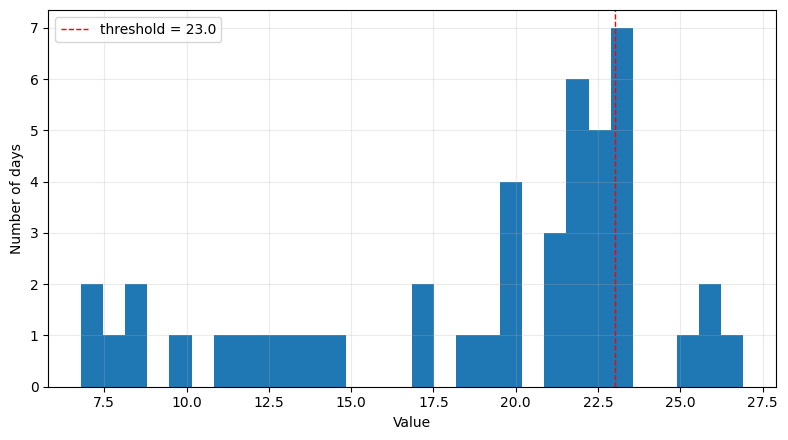

 Saved scenario 'hot_temp_mean_ge_23.0C' → D:/Desktop/MSc Thesis/Results/scenarios\hot_temp_mean_ge_23.0C.csv


In [10]:
cut_hot = 23.0

hot_days, diag_hot = find_days_by_city_metric(
        WEATHER_CSV,
        metric="temperature",        # "temperature" | "humidity" | "pm10" | "heat_index"
        station_stat="max",          # "max" | "mean" | "min" | "pXX" (e.g., "p95")
        threshold_mode="absolute",   # "absolute" | "percentile" | "topk"
        threshold_value=cut_hot,        # used if absolute & high tail (e.g., °C, %RH, µg/m³)
        tail="high",                 # "high" for hot/humid/polluted; "low" for cold
        min_coverage=0.3,            # require >=30% of stations present that day
        align_to_model_days=True,
        art_path_for_alignment=ART,
        include_history_days=True
    )

plt.figure(figsize=(8,4.5))
diag_hot["city_median"].hist(bins=30)
plt.axvline(cut_hot, linestyle="--", linewidth=1, color='r', label=f"threshold = {cut_hot}")
plt.legend()
plt.xlabel("Value"); plt.ylabel("Number of days"); plt.grid(True, alpha=0.25)
plt.tight_layout(); plt.show()


save_scenario_dates(
    name=f"hot_temp_mean_ge_{cut_hot:.1f}C",
    dates=hot_days,
    extra={
        "metric": "temperature",
        "station_stat": "mean",
        "threshold_mode": "absolute",
        "threshold_value": cut_hot,
        "tail": "high",
        "min_coverage": 0.3,
        "aligned_to_model": True,
        "include_history_days": True
    }
)

C:\Users\Michele\AppData\Local\Temp\ipykernel_10792\1404102679.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  art = torch.load(art_path, map_location="cpu")


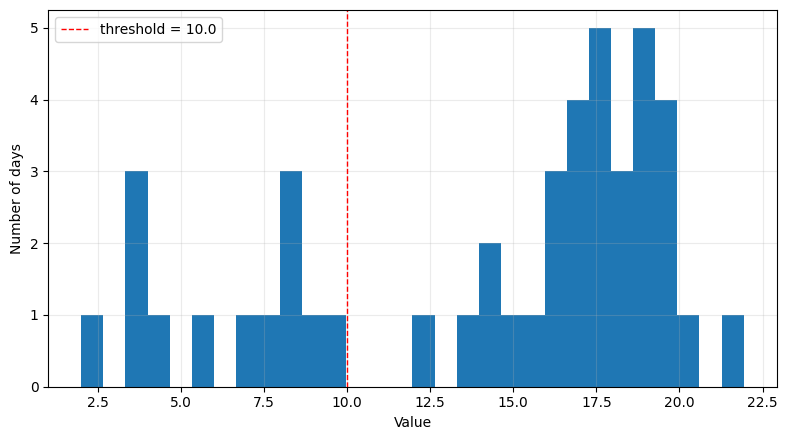

 Saved scenario 'cold_temp_mean_le_10.0C' → D:/Desktop/MSc Thesis/Results/scenarios\cold_temp_mean_le_10.0C.csv


In [11]:
cut_cold = 10.0

cold_days, diag_cold = find_days_by_city_metric(
        WEATHER_CSV,
        metric="temperature",        # "temperature" | "humidity" | "pm10" | "heat_index"
        station_stat="mean",          # "max" | "mean" | "min" | "pXX" (e.g., "p95")
        threshold_mode="absolute",   # "absolute" | "percentile" | "topk"
        threshold_value=cut_cold,        # used if absolute & high tail (e.g., °C, %RH, µg/m³)
        tail="low",                  # "high" for hot/humid/polluted; "low" for cold
        min_coverage=0.3,            # require >=30% of stations present that day
        align_to_model_days=True,
        art_path_for_alignment=ART,
        include_history_days=True
    )

plt.figure(figsize=(8,4.5))
diag_cold["city_median"].hist(bins=30)
plt.axvline(cut_cold, linestyle="--", linewidth=1, color='r', label=f"threshold = {cut_cold}")
plt.legend()
plt.xlabel("Value"); plt.ylabel("Number of days"); plt.grid(True, alpha=0.25)
plt.tight_layout(); plt.show()

save_scenario_dates(
    name=f"cold_temp_mean_le_{cut_cold:.1f}C",
    dates=cold_days,
    extra={
        "metric": "temperature",
        "station_stat": "mean",
        "threshold_mode": "absolute",
        "threshold_value": cut_cold,
        "tail": "low",
        "min_coverage": 0.3
    }
)

C:\Users\Michele\AppData\Local\Temp\ipykernel_10792\1404102679.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  art = torch.load(art_path, map_location="cpu")


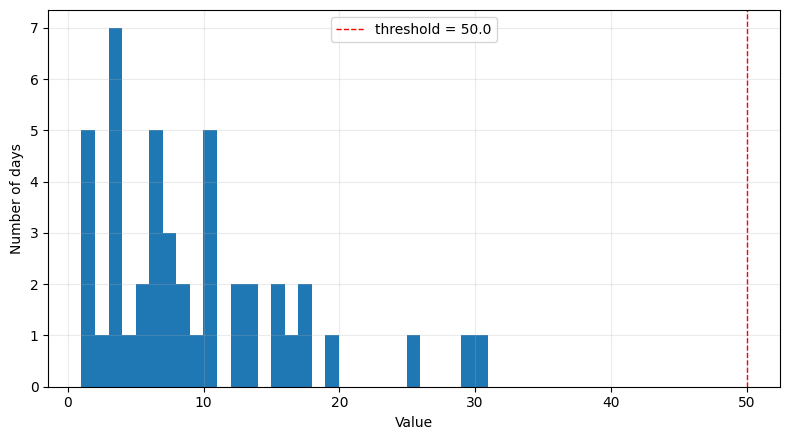

 Saved scenario 'pm10_mean_ge_50ugm3' → D:/Desktop/MSc Thesis/Results/scenarios\pm10_mean_ge_50ugm3.csv


In [12]:
cut_polluted = 50.0

polluted_days, diag_polluted = find_days_by_city_metric(
        WEATHER_CSV,
        metric="pm10",        # "temperature" | "humidity" | "pm10" | "heat_index"
        station_stat="mean",          # "max" | "mean" | "min" | "pXX" (e.g., "p95")
        threshold_mode="absolute",   # "absolute" | "percentile" | "topk"
        threshold_value=cut_polluted,        # used if absolute & high tail (e.g., °C, %RH, µg/m³)
        tail="high",                  # "high" for hot/humid/polluted; "low" for cold
        min_coverage=0.3,            # require >=30% of stations present that day
        align_to_model_days=True,
        art_path_for_alignment=ART,
        include_history_days=True
    )

plt.figure(figsize=(8,4.5))
diag_polluted["city_median"].hist(bins=30)
plt.axvline(cut_polluted, linestyle="--", linewidth=1, color='r', label=f"threshold = {cut_polluted}")
plt.legend()
plt.xlabel("Value"); plt.ylabel("Number of days"); plt.grid(True, alpha=0.25)
plt.tight_layout(); plt.show()


save_scenario_dates(
    name=f"pm10_mean_ge_{int(cut_polluted)}ugm3",
    dates=polluted_days,
    extra={"metric": "pm10", "station_stat": "mean", "threshold_mode": "absolute",
           "threshold_value": cut_polluted, "tail": "high", "min_coverage": 0.3}
)

C:\Users\Michele\AppData\Local\Temp\ipykernel_10792\1404102679.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  art = torch.load(art_path, map_location="cpu")


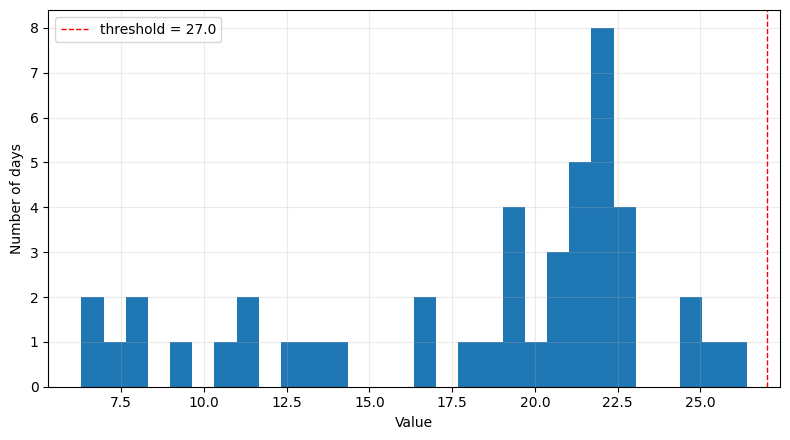

 Saved scenario 'heat_index_max_ge_27.0C' → D:/Desktop/MSc Thesis/Results/scenarios\heat_index_max_ge_27.0C.csv


In [13]:
cut_hi = 27.0

hdi_days, diag_hi = find_days_by_city_metric(
        WEATHER_CSV,
        metric="heat_index",        # "temperature" | "humidity" | "pm10" | "heat_index"
        station_stat="max",          # "max" | "mean" | "min" | "pXX" (e.g., "p95")
        threshold_mode="absolute",   # "absolute" | "percentile" | "topk"
        threshold_value=cut_hi,        # used if absolute & high tail (e.g., °C, %RH, µg/m³)
        tail="high",                  # "high" for hot/humid/polluted; "low" for cold
        min_coverage=0.3,            # require >=30% of stations present that day
        align_to_model_days=True,
        art_path_for_alignment=ART,
        include_history_days=True
    )

plt.figure(figsize=(8,4.5))
diag_hi["city_median"].hist(bins=30)
plt.axvline(cut_hi, linestyle="--", linewidth=1, color='r', label=f"threshold = {cut_hi}")
plt.legend()
plt.xlabel("Value"); plt.ylabel("Number of days"); plt.grid(True, alpha=0.25)
plt.tight_layout(); plt.show()


save_scenario_dates(
    name=f"heat_index_max_ge_{cut_hi:.1f}C",
    dates=hdi_days,
    extra={"metric": "heat_index", "station_stat": "max", "threshold_mode": "absolute",
           "threshold_value": cut_hi, "tail": "high", "min_coverage": 0.3}
)

C:\Users\Michele\AppData\Local\Temp\ipykernel_10792\1404102679.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  art = torch.load(art_path, map_location="cpu")


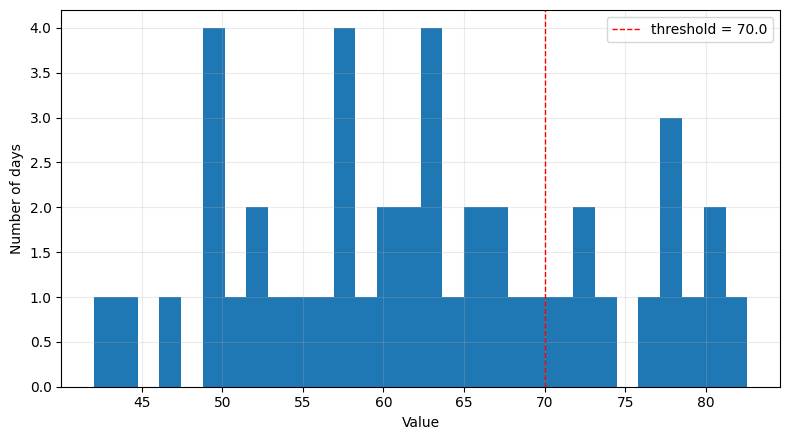

 Saved scenario 'humidity_mean_ge_70.0C' → D:/Desktop/MSc Thesis/Results/scenarios\humidity_mean_ge_70.0C.csv


In [16]:
cut_humid = 70.0

humid_days, diag_humid = find_days_by_city_metric(
        WEATHER_CSV,
        metric="humidity",        # "temperature" | "humidity" | "pm10" | "heat_index"
        station_stat="mean",          # "max" | "mean" | "min" | "pXX" (e.g., "p95")
        threshold_mode="absolute",   # "absolute" | "percentile" | "topk"
        threshold_value=cut_humid,        # used if absolute & high tail (e.g., °C, %RH, µg/m³)
        tail="high",                  # "high" for hot/humid/polluted; "low" for cold
        min_coverage=0.3,            # require >=30% of stations present that day
        align_to_model_days=True,
        art_path_for_alignment=ART,
        include_history_days=True
    )

plt.figure(figsize=(8,4.5))
diag_humid["city_median"].hist(bins=30)
plt.axvline(cut_humid, linestyle="--", linewidth=1, color='r', label=f"threshold = {cut_humid}")
plt.legend()
plt.xlabel("Value"); plt.ylabel("Number of days"); plt.grid(True, alpha=0.25)
plt.tight_layout(); plt.show()


save_scenario_dates(
    name=f"humidity_mean_ge_{cut_humid:.1f}C",
    dates=humid_days,
    extra={"metric": "humidity", "station_stat": "mean", "threshold_mode": "absolute",
           "threshold_value": cut_humid, "tail": "high", "min_coverage": 0.3}
)